# SPS Machine Learning Tutorial, Part 1
---
January 29/30, 2020 // Luc Le Pottier, University of Michigan


##### first: a cool viz which didn't fit last time
just because I didn't have time, here's another cool way of visualizing dimensional data.

Here we will show a cool method of transforming sound files (.wav), which are in the amplitude-time domain, to the frequency-time domain. 

First we get some .wav files: 

In [39]:
!wget -q https://github.com/luclepot/SPS_ml_tutorial/raw/master/data/synths/SYNTH-FancyPoly800Dazed.wav https://github.com/luclepot/SPS_ml_tutorial/raw/master/data/synths/SYNTH-PWMRezzzzzzz.wav
!ls *.wav

SYNTH-FancyPoly800Dazed.wav  SYNTH-PWMRezzzzzzz.wav


Then we can make what is called a spectrogram; basically, an image of the behavior of the .wav file in time, as a function of intensity.

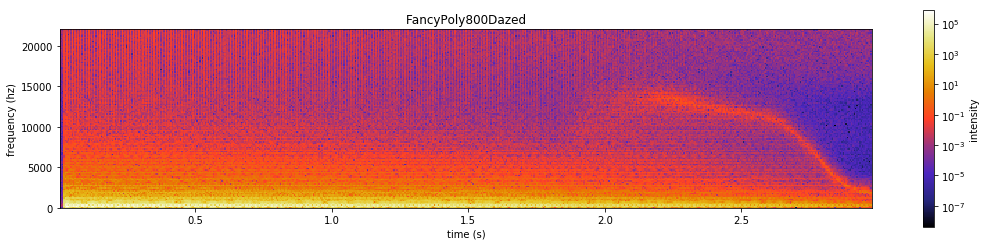

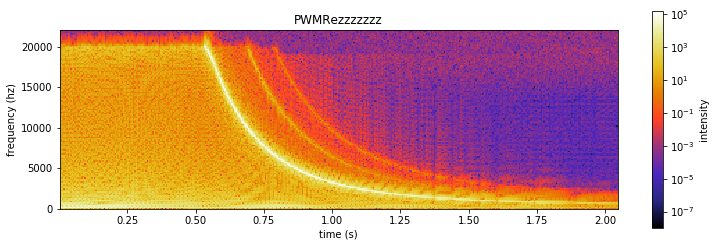

In [112]:
import numpy as np
import scipy.signal
import scipy.io.wavfile
import matplotlib.pyplot as plt 
import matplotlib.colors as plt_colors
import glob

filenames = glob.glob('SYNTH-*.wav')
for path in filenames:
    
    name = path.split('-')[-1].replace('.wav', '')
    sample_rate, data = scipy.io.wavfile.read(path)
    f,t,Sxx = scipy.signal.spectrogram(data, fs=sample_rate, return_onesided=True)

    plt.figure(figsize=(4*len(t)/len(f),4))
    plt.pcolormesh(t, f, Sxx, cmap='CMRmap', norm=plt_colors.LogNorm())
    plt.colorbar().set_label('intensity')

    plt.ylabel('frequency (hz)')
    plt.xlabel('time (s)')
    plt.gca().set_aspect(t.max()/f.max() * len(f)/len(t))
    plt.title(name)
    plt.show()


## 1. Building models

In [114]:
! pip install tensorflow

     |████████████████████████████████| 421.8MB 45kB/s  eta 0:00:019   |▉                               | 11.0MB 2.2MB/s eta 0:03:06     |██████████                      | 132.1MB 958kB/s eta 0:05:03     |████████████████████▍           | 268.9MB 6.0MB/s eta 0:00:26     |████████████████████▍           | 269.4MB 6.0MB/s eta 0:00:26     |█████████████████████           | 275.9MB 4.5MB/s eta 0:00:33     |█████████████████████           | 277.7MB 3.4MB/s eta 0:00:43     |█████████████████████▎          | 280.4MB 3.4MB/s eta 0:00:43     |█████████████████████▎          | 280.7MB 2.1MB/s eta 0:01:09�█████████▍          | 281.3MB 2.1MB/s eta 0:01:09     |█████████████████████▌          | 284.0MB 2.1MB/s eta 0:01:07     |█████████████████████▋          | 284.6MB 4.3MB/s eta 0:00:32     |█████████████████████▋          | 285.0MB 4.3MB/s eta 0:00:32     |█████████████████████▋          | 285.1MB 4.3MB/s eta 0:00:32     |█████████████████████▉          | 287.8MB 1.6MB/s eta 0:01:26     |████████

     |████████████████████████████████| 81kB 6.4MB/s  eta 0:00:01
     |████████████████████████████████| 153kB 6.8MB/s eta 0:00:01
  Stored in directory: /home/luclepot/.cache/pip/wheels/8e/28/49/fad4e7f0b9a1227708cbbee4487ac8558a7334849cb81c813d
  Stored in directory: /home/luclepot/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Stored in directory: /home/luclepot/.cache/pip/wheels/2c/b1/94/43d03e130b929aae7ba3f8d15cbd7bc0d1cb5bb38a5c721833
  Stored in directory: /home/luclepot/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Stored in directory: /home/luclepot/.cache/pip/wheels/d7/de/2e/efa132238792efb6459a96e85916ef8597fcb3d2ae51590dfd
Successfully built absl-py gast opt-einsum termcolor wrapt
ERROR: madminer 0.3.0 requires recommonmark, which is not installed.
ERROR: madminer 0.3.0 requires scikit-hep, which is not installed.
ERROR: madminer 0.3.0 requires sphinx_rtd_theme, which is not installed.
ERROR: madminer 0.3.